## Conect To Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import pickle
import random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("✅ تم استيراد المكتبات بنجاح!")

✅ تم استيراد المكتبات بنجاح!


## Setting the random seed for consistent results

In [ ]:
np.random.seed(0)

## Impoting Data

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Receiving objects: 100% (6/6), 117.80 MiB | 17.06 MiB/s, done.
Updating files: 100% (4/4), done.


## Extracting dataset splits from pickle files

In [ ]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

## Data Splitting

In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


## Validating dataset consistency and image dimensions

In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

## Data Visualisation

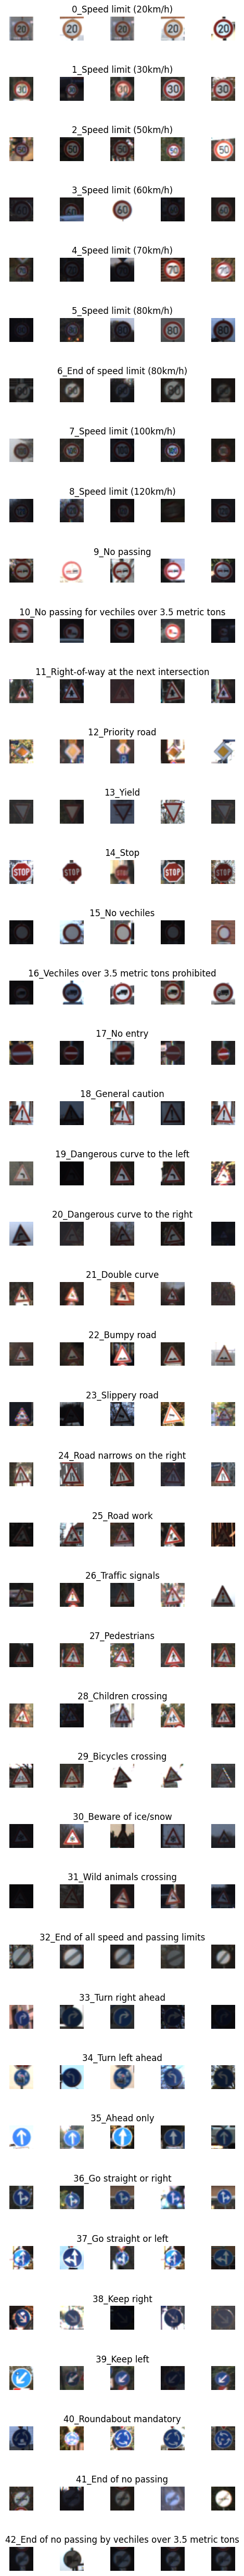

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))



## Dataset Distribution Analysis

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

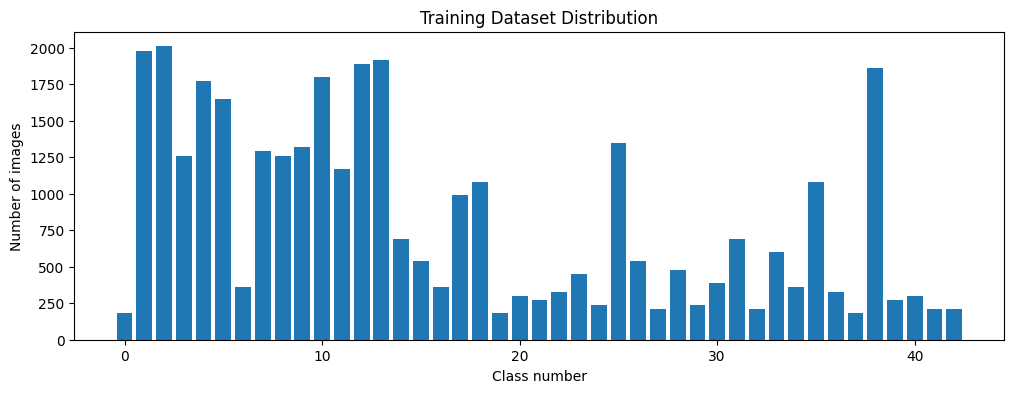

In [ ]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Training Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")


## Data Preprocessing

(32, 32, 3)
36


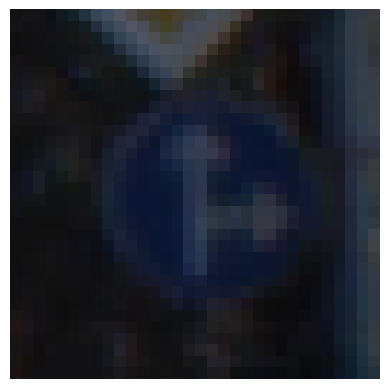

In [ ]:
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [ ]:
def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    return image

(32, 32)


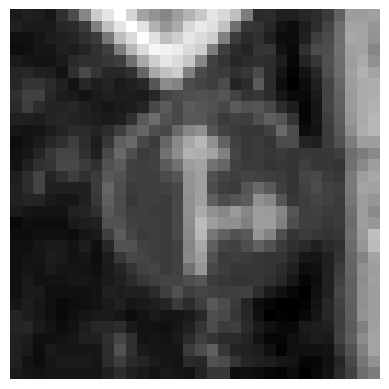

In [ ]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

### Applying Histogram Equalization to improve image contrast

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


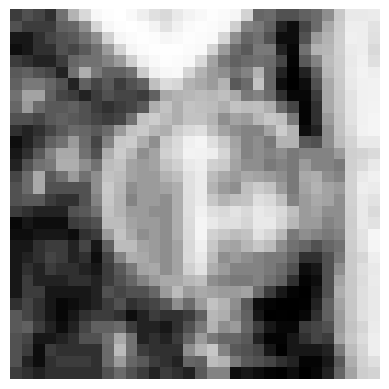

In [ ]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

In [ ]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

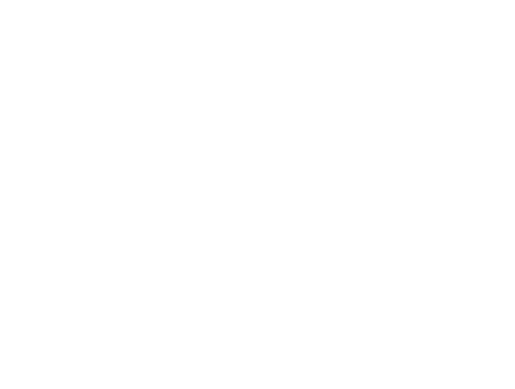

In [ ]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

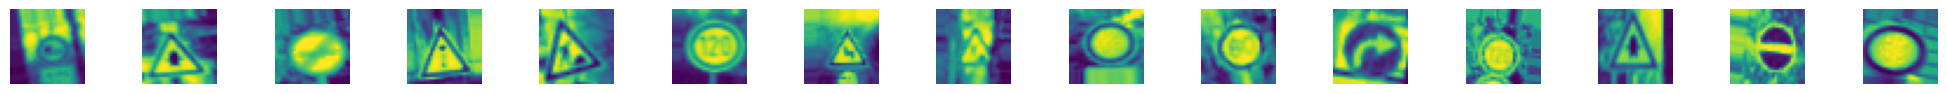

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [ ]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

## Neural Network

In [ ]:

from keras.layers import Input

def neural_model():
    model = Sequential()

    # 1. التعديل الأول: استخدام Input object بدلاً من input_shape داخل الطبقة
    model.add(Input(shape=(32, 32, 1)))

    # 2. طبقات الـ Convolution
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))

    # تأكد من أن num_classes معرف لديك بـ 43
    model.add(Dense(num_classes, activation='softmax'))

    # 3. التعديل الثاني الحاسم: تغيير 'lr' إلى 'learning_rate'
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = neural_model()
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
import numpy as np

# 1. إصلاح أبعاد y_train إذا كانت مشوهة (تحويلها من 3D إلى 1D ثم إلى 2D الصحيح)
if len(y_train.shape) > 2:
    y_train = np.argmax(y_train, axis=1)
if len(y_val.shape) > 2:
    y_val = np.argmax(y_val, axis=1)

# 2. التأكد من التحويل لـ One-Hot Encoding لمرة واحدة فقط (الشكل المطلوب: None, 43)
if len(y_train.shape) == 1 or y_train.shape[1] != 43:
    y_train = to_categorical(y_train, 43)
    y_val = to_categorical(y_val, 43)

# 3. طباعة الأبعاد للتأكد قبل البدء (يجب أن تظهر 43 في خانة واحدة فقط)
print("Corrected y_train shape:", y_train.shape) # يجب أن يطبع (عدد الصور, 43)

# 4. تشغيل التدريب الآن
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch=len(X_train) // 50,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    shuffle=True)

Corrected y_train shape: (34799, 43)
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


695/695 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.2985 - loss: 2.5697 - val_accuracy: 0.8948 - val_loss: 0.3406
Epoch 2/10
  1/695 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7400 - loss: 0.8067

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.7400 - loss: 0.8067 - val_accuracy: 0.8930 - val_loss: 0.3469
Epoch 3/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8119 - loss: 0.6122 - val_accuracy: 0.9619 - val_loss: 0.1305
Epoch 4/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.9200 - loss: 0.2599 - val_accuracy: 0.9621 - val_loss: 0.1265
Epoch 5/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8956 - loss: 0.3430 - val_accuracy: 0.9732 - val_loss: 0.0811
Epoch 6/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.9200 - loss: 0.3751 - val_accuracy: 0.9717 - val_loss: 0.0840
Epoch 7/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9253 - loss: 0.2436 - val_accuracy: 0.9714 - val_loss: 0.1035
Epoch 8/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.8800 - loss: 0.2679 - val_accuracy: 0.9751 - val_loss: 0.0864
Epoch 9/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9360 - loss: 0.2047 - val_accurac

In [ ]:
# حفظ الموديل بصيغة h5 في درايف
model.save('/content/drive/MyDrive/traffic_sign_model.h5')
print("تم حفظ الموديل بنجاح في Google Drive!")

تم حفظ الموديل بنجاح في Google Drive!


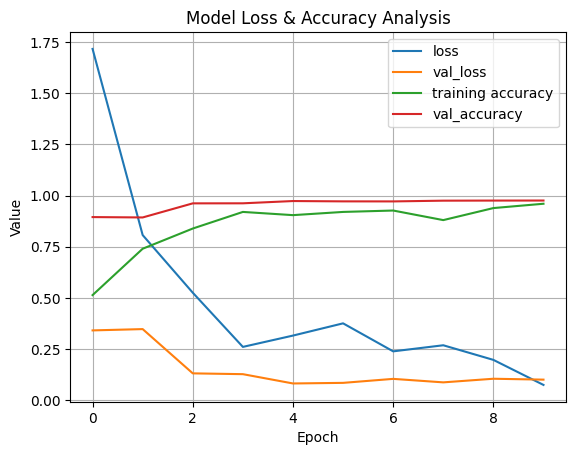

In [ ]:
# رسم منحنيات الخسارة والدقة
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy']) # التعديل هنا
plt.plot(history.history['val_accuracy']) # والتعديل هنا

plt.legend(['loss', 'val_loss', 'training accuracy', 'val_accuracy'])
plt.title('Model Loss & Accuracy Analysis')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True) # إضافة شبكة خلفية لجعل الرسم أوضح
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test Score', score[0])
print('Test Accuracy', score[1])

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9615 - loss: 0.1276
Test Score 0.13036181032657623
Test Accuracy 0.9607284069061279


## Testing

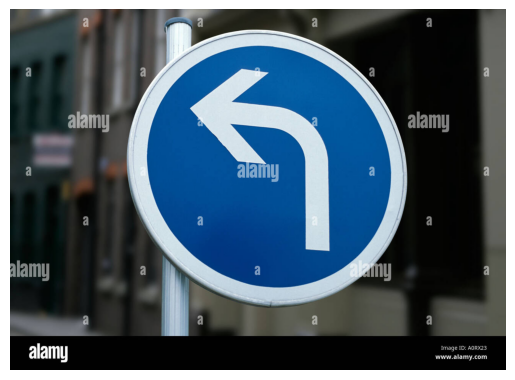

In [ ]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
image = Image.open(r.raw)
plt.axis('off')
plt.imshow(image, cmap=plt.get_cmap('gray'))

(32, 32)


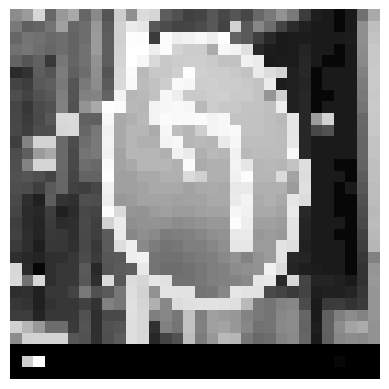

In [ ]:
img = np.asarray(image)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [ ]:
import numpy as np

# 1. الحصول على احتمالات جميع الفئات
predictions = model.predict(img)

# 2. استخراج رقم الفئة ذات أعلى احتمالية
predicted_class = np.argmax(predictions, axis=-1)

# 3. طباعة النتيجة (تحويلها لنص)
print("predicted sign: " + str(predicted_class[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
predicted sign: 5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


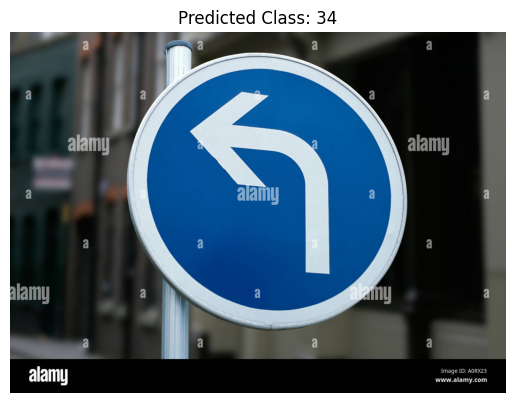

🔍 النتيجة: الموديل يتوقع أن هذه الإشارة هي الفئة رقم: 34


In [ ]:
import requests
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. ضع رابط أي صورة إشارة مرور هنا (اخترت لك إشارة تحديد سرعة 30 كم/س)
url = 'https://c8.alamy.com/comp/A0RX23/india-karnataka-bangalore-road-sign-speed-limit-30-kmh-A0RX23.jpg'

try:
    # 2. تحميل الصورة من الإنترنت
    response = requests.get(url, stream=True)
    img = Image.open(response.raw)
    img_array = np.asarray(img)

    # 3. المعالجة (التحويل لرمادي، تسوية التباين، تغيير الحجم)
    img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    img_equalized = cv2.equalizeHist(img_gray)
    img_normalized = img_equalized / 255
    img_resized = cv2.resize(img_normalized, (32, 32))
    img_final = img_resized.reshape(1, 32, 32, 1)

    # 4. التوقع
    predictions = model.predict(img_final)
    pred_class = np.argmax(predictions, axis=-1)[0]

    # 5. العرض
    plt.imshow(img_array)
    plt.title(f"Predicted Class: {pred_class}")
    plt.axis('off')
    plt.show()

    print(f"🔍 النتيجة: الموديل يتوقع أن هذه الإشارة هي الفئة رقم: {pred_class}")

except Exception as e:
    print(f"❌ حدث خطأ أثناء جلب الصورة: {e}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


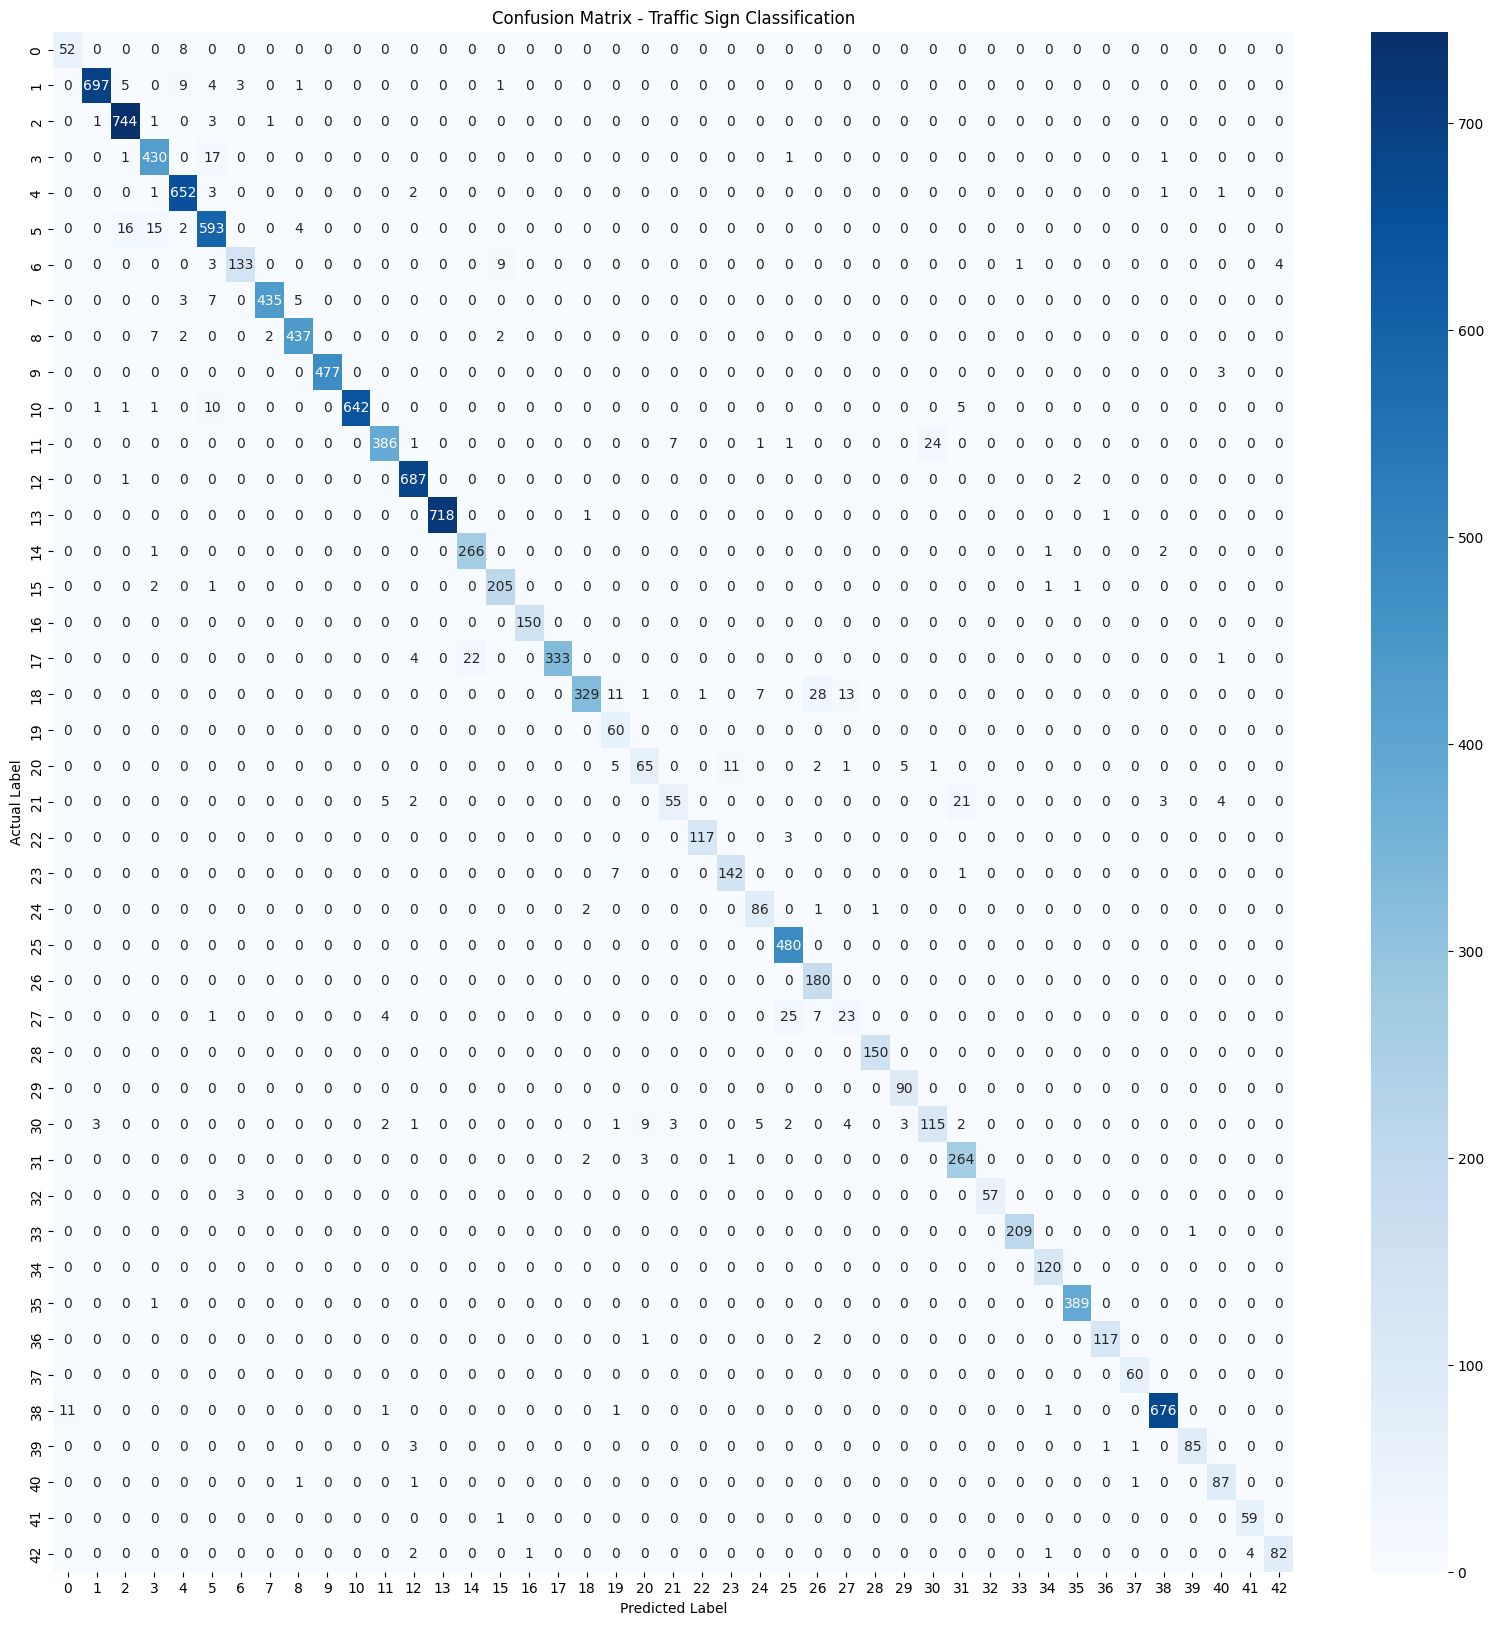


--- Detailed Classification Report ---

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        60
           1       0.99      0.97      0.98       720
           2       0.97      0.99      0.98       750
           3       0.94      0.96      0.95       450
           4       0.96      0.99      0.98       660
           5       0.92      0.94      0.93       630
           6       0.96      0.89      0.92       150
           7       0.99      0.97      0.98       450
           8       0.98      0.97      0.97       450
           9       1.00      0.99      1.00       480
          10       1.00      0.97      0.99       660
          11       0.97      0.92      0.94       420
          12       0.98      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.92      0.99      0.95       270
          15       0.94      0.98      0.96       210
          16       0.99      1.00      1

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. الحصول على التوقعات من النموذج لمجموعة الاختبار
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2. إنشاء مصفوفة الارتباك
cm = confusion_matrix(y_true, y_pred_classes)

# 3. رسم المصفوفة بشكل احترافي
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Traffic Sign Classification')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. طباعة تقرير الدقة التفصيلي لكل إشارة
print("\n--- Detailed Classification Report ---\n")
print(classification_report(y_true, y_pred_classes))

In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# 1. تحميل الموديل من المسار الذي حفظناه فيه في الدرايف
model_path = '/content/drive/MyDrive/traffic_sign_model.h5'
loaded_model = load_model(model_path)

print("✅ تم تحميل الموديل بنجاح! هو الآن جاهز للاختبار.")

✅ تم تحميل الموديل بنجاح! هو الآن جاهز للاختبار.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


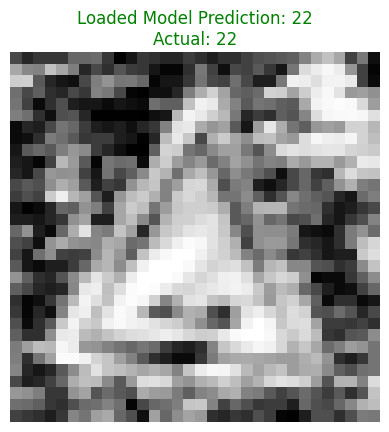

✅ الموديل المحمّل نجح في التعرف على الإشارة (الفئة 22)


In [ ]:
import matplotlib.pyplot as plt

# 1. اختيار صورة عشوائية من X_test
random_index = np.random.randint(0, len(X_test))
test_image = X_test[random_index]

# 2. التوقع باستخدام الموديل الذي قمنا بتحميله للتو
# نقوم بعمل reshape للصورة لتناسب مدخلات الموديل (1, 32, 32, 1)
prediction_probs = loaded_model.predict(test_image.reshape(1, 32, 32, 1))
predicted_class = np.argmax(prediction_probs)
actual_class = np.argmax(y_test[random_index])

# 3. عرض النتيجة
plt.imshow(test_image.reshape(32, 32), cmap='gray')
plt.axis('off')
color = "green" if predicted_class == actual_class else "red"
plt.title(f"Loaded Model Prediction: {predicted_class}\nActual: {actual_class}", color=color)
plt.show()

if predicted_class == actual_class:
    print(f"✅ الموديل المحمّل نجح في التعرف على الإشارة (الفئة {predicted_class})")

In [ ]:
classes_ar = { 0:'تحديد السرعة (20 كم/س)',
               1:'تحديد السرعة (30 كم/س)',
               2:'تحديد السرعة (50 كم/س)',
               3:'تحديد السرعة (60 كم/س)',
               4:'تحديد السرعة (70 كم/س)',
               5:'تحديد السرعة (80 كم/س)',
               6:'نهاية منطقة تحديد السرعة (80 كم/س)',
               7:'تحديد السرعة (100 كم/س)',
               8:'تحديد السرعة (120 كم/س)',
               9:'ممنوع التجاوز',
               10:'ممنوع التجاوز للشاحنات (> 3.5 طن)',
               11:'حق الأولوية عند التقاطع',
               12:'طريق ذو أولوية',
               13:'أفسح الطريق (Yield)',
               14:'قف (Stop)',
               15:'ممنوع مرور المركبات',
               16:'ممنوع مرور الشاحنات (> 3.5 طن)',
               17:'ممنوع الدخول',
               18:'تحذير عام (خطر)',
               19:'منحنى خطر لليسار',
               20:'منحنى خطر لليمين',
               21:'منحنيات مزدوجة',
               22:'طريق وعر (مطبات)',
               23:'طريق زلق',
               24:'طريق يضيق من اليمين',
               25:'أعمال طرق',
               26:'إشارات ضوئية',
               27:'عبور مشاة',
               28:'عبور أطفال',
               29:'عبور دراجات هوائية',
               30:'احذر من الجليد/الثلج',
               31:'عبور حيوانات برية',
               32:'نهاية جميع قيود السرعة والتجاوز',
               33:'إلزام بالاتجاه لليمين',
               34:'إلزام بالاتجاه لليسار',
               35:'إلزام بالاتجاه للأمام فقط',
               36:'إلزام بالاتجاه للأمام أو اليمين',
               37:'إلزام بالاتجاه للأمام أو اليسار',
               38:'ابق على اليمين',
               39:'ابق على اليسار',
               40:'دوار إلزامي',
               41:'نهاية منع التجاوز',
               42:'نهاية منع التجاوز للشاحنات' }

In [ ]:
def get_gradcam_heatmap(img_array, model):
    # 1. البحث عن آخر طبقة Conv2D
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if 'conv2d' in layer.name:
            last_conv_layer_name = layer.name
            break

    # 2. إنشاء موديل يخرج نتائج الطبقة الأخيرة والنتائج النهائية
    # هنا نستخدم مدخلات الطبقة الأولى ومخرجات الطبقة المطلوبة
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 3. تسجيل العمليات الحسابية لاستخراج الاشتقاقات
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 4. حساب الاشتقاقات (Gradients)
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 5. معالجة الأوزان (Global Average Pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 6. دمج الأوزان مع مخرجات الطبقة (Heatmap)
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 7. التنسيق النهائي للخريطة الحرارية
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


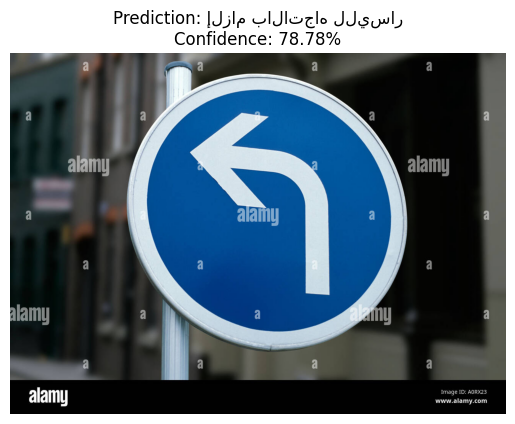

✅ النتيجة: إلزام بالاتجاه لليسار
🎯 نسبة الثقة: 78.78%


In [ ]:
# 1. الحصول على احتمالات جميع الفئات
predictions = model.predict(img_final)

# 2. استخراج الفئة الأعلى احتمالاً ونسبة التأكد
pred_class = np.argmax(predictions, axis=-1)[0]
confidence = np.max(predictions) * 100  # تحويلها لنسبة مئوية

# 3. عرض النتيجة
plt.imshow(img_array)
plt.title(f"Prediction: {classes_ar[pred_class]}\nConfidence: {confidence:.2f}%")
plt.axis('off')
plt.show()

print(f"✅ النتيجة: {classes_ar[pred_class]}")
print(f"🎯 نسبة الثقة: {confidence:.2f}%")

In [ ]:
# كود تنشيط النموذج (Activation)
import numpy as np

# نقوم بإنشاء بيانات وهمية بنفس شكل المدخلات (صورة واحدة 32x32 رمادية)
dummy_input = np.zeros((1, 32, 32, 1))
# تمريرها عبر الموديل لتنشيط الطبقات
model.predict(dummy_input)

print("✅ تم تنشيط النموذج وجاهز لاستخراج Grad-CAM!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ تم تنشيط النموذج وجاهز لاستخراج Grad-CAM!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


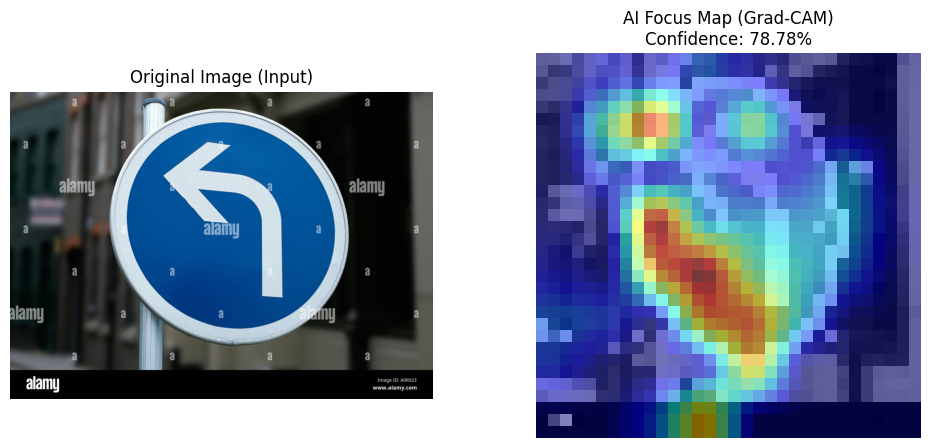

✅ تم التعرف على: إلزام بالاتجاه لليسار


In [ ]:
# ==========================================
# النسخة "الخارقة" والنهائية - خالية من أخطاء الطبقات
# ==========================================

import tensorflow as tf
from gtts import gTTS
import IPython.display as ipd
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. القاموس العربي (تأكد من وجوده)
if 'classes_ar' not in locals():
    classes_ar = {i: f"الفئة {i}" for i in range(43)} # قاموس احتياطي

# 2. دالة Grad-CAM الاحترافية (تم تعديلها لتجنب خطأ sequential_2)
def compute_gradcam(model, img_array):
    # البحث عن آخر طبقة Conv2D
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if 'conv2d' in layer.name.lower():
            last_conv_layer_name = layer.name
            break

    # بناء نموذج وظيفي (Functional Model) من النموذج الحالي
    # هذا الإجراء يحل مشكلة "never been called" نهائياً
    img_input = tf.keras.Input(shape=(32, 32, 1))
    x = img_input
    intermediate_output = None

    # إعادة بناء المسار برمجياً للوصول للطبقة المطلوبة
    for layer in model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            intermediate_output = x

    grad_model = tf.keras.models.Model(img_input, [intermediate_output, x])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    # استخراج التدرجات
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # حساب الخريطة الحرارية
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# 3. دالة الاختبار الذكي الشاملة
def final_smart_test(img_path_or_url):
    try:
        import requests
        from PIL import Image

        # تحميل ومعالجة الصورة
        response = requests.get(img_path_or_url, stream=True)
        img_pil = Image.open(response.raw).convert('RGB')
        img_array = np.asarray(img_pil)

        # المعالجة الخاصة بالنموذج
        gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        equ = cv2.equalizeHist(gray)
        norm = equ / 255.0
        resized = cv2.resize(norm, (32, 32))
        final_input = resized.reshape(1, 32, 32, 1)

        # التوقع بنسبة الثقة
        preds = model.predict(final_input)
        pred_class = np.argmax(preds)
        confidence = np.max(preds) * 100
        result_text = classes_ar.get(pred_class, "إشارة غير معروفة")

        # توليد الخريطة الحرارية (Grad-CAM)
        heatmap = compute_gradcam(model, final_input)

        # عرض النتائج البصرية
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.imshow(img_array)
        ax1.set_title("Original Image (Input)")
        ax1.axis('off')

        # دمج الخريطة مع الصورة
        ax2.imshow(resized, cmap='gray')
        ax2.imshow(cv2.resize(heatmap, (32, 32)), alpha=0.5, cmap='jet')
        ax2.set_title(f"AI Focus Map (Grad-CAM)\nConfidence: {confidence:.2f}%")
        ax2.axis('off')
        plt.show()

        print(f"✅ تم التعرف على: {result_text}")

        # نظام النطق الصوتي
        tts = gTTS(text=f"انتبه، {result_text}", lang='ar')
        tts.save('alert.mp3')
        return ipd.Audio('alert.mp3', autoplay=True)

    except Exception as e:
        print(f"❌ خطأ تقني: {e}")

# التشغيل النهائي
test_url = "https://c8.alamy.com/comp/A0RX23/india-karnataka-bangalore-road-sign-speed-limit-30-kmh-A0RX23.jpg"
final_smart_test(test_url)